In [43]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import GPE_ensemble as GPE

from GPErks.gp.experiment import GPExperiment
from GPErks.train.emulator import GPEmulator
from GPErks.perks.inference import Inference
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion, 
)
from GPErks.train.early_stop import PkEarlyStoppingCriterion

import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split

# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
n = 50
m = 10

In [45]:
x = np.linspace(-5,5,n)

In [46]:
theta = np.linspace(1,10,m)

In [47]:
xtheta = np.array(np.multiply.outer(theta,x)).reshape(m*n)

In [48]:
xtheta

array([ -5.        ,  -4.79591837,  -4.59183673,  -4.3877551 ,
        -4.18367347,  -3.97959184,  -3.7755102 ,  -3.57142857,
        -3.36734694,  -3.16326531,  -2.95918367,  -2.75510204,
        -2.55102041,  -2.34693878,  -2.14285714,  -1.93877551,
        -1.73469388,  -1.53061224,  -1.32653061,  -1.12244898,
        -0.91836735,  -0.71428571,  -0.51020408,  -0.30612245,
        -0.10204082,   0.10204082,   0.30612245,   0.51020408,
         0.71428571,   0.91836735,   1.12244898,   1.32653061,
         1.53061224,   1.73469388,   1.93877551,   2.14285714,
         2.34693878,   2.55102041,   2.75510204,   2.95918367,
         3.16326531,   3.36734694,   3.57142857,   3.7755102 ,
         3.97959184,   4.18367347,   4.3877551 ,   4.59183673,
         4.79591837,   5.        , -10.        ,  -9.59183673,
        -9.18367347,  -8.7755102 ,  -8.36734694,  -7.95918367,
        -7.55102041,  -7.14285714,  -6.73469388,  -6.32653061,
        -5.91836735,  -5.51020408,  -5.10204082,  -4.69

In [59]:
y = xtheta + np.random.normal(0,1,n*m)

In [60]:
y.shape

(500,)

In [61]:
data = np.vstack((np.tile(x,m),np.repeat(theta,n)))

In [62]:
data

array([[-5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
        -3.97959184, -3.7755102 , -3.57142857, -3.36734694, -3.16326531,
        -2.95918367, -2.75510204, -2.55102041, -2.34693878, -2.14285714,
        -1.93877551, -1.73469388, -1.53061224, -1.32653061, -1.12244898,
        -0.91836735, -0.71428571, -0.51020408, -0.30612245, -0.10204082,
         0.10204082,  0.30612245,  0.51020408,  0.71428571,  0.91836735,
         1.12244898,  1.32653061,  1.53061224,  1.73469388,  1.93877551,
         2.14285714,  2.34693878,  2.55102041,  2.75510204,  2.95918367,
         3.16326531,  3.36734694,  3.57142857,  3.7755102 ,  3.97959184,
         4.18367347,  4.3877551 ,  4.59183673,  4.79591837,  5.        ,
        -5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
        -3.97959184, -3.7755102 , -3.57142857, -3.36734694, -3.16326531,
        -2.95918367, -2.75510204, -2.55102041, -2.34693878, -2.14285714,
        -1.93877551, -1.73469388, -1.53061224, -1.3

In [63]:
X = pd.DataFrame(data.T)
Y = pd.DataFrame(y)

In [64]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=seed
)

In [65]:
y_train

,0
231,6.151014
412,-21.444328
92,5.839544
284,11.009555
44,3.107824
...,...
133,3.927891
361,-21.540730
497,46.355813
340,22.689853


In [66]:
X_train

,0,1
231,1.326531,5.0
412,-2.551020,9.0
92,3.571429,2.0
284,1.938776,6.0
44,3.979592,1.0
...,...,...
133,1.734694,3.0
361,-2.755102,8.0
497,4.591837,10.0
340,3.163265,7.0


In [67]:
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

0


In [68]:
emulator.R2(X_test,y_test)

tensor([0.9970], dtype=torch.float64, grad_fn=<RsubBackward1>)

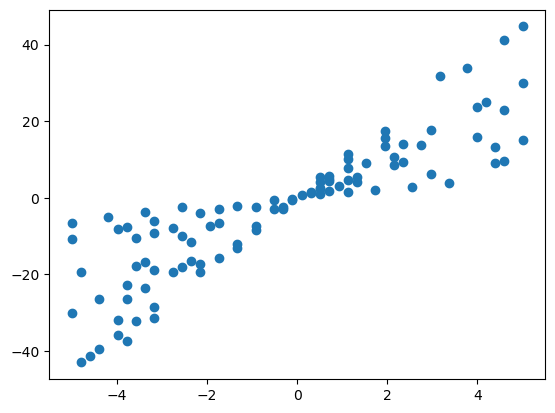

In [69]:
plt.plot(X_test.iloc[:,0],emulator.predict(X_test).detach().numpy(),'o')

In [70]:
emulator.models

[ExactLRGPModel(
   (likelihood): GaussianLikelihood(
     (noise_covar): HomoskedasticNoise(
       (raw_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (mean_module): LinearMean()
   (covar_module): ScaleKernel(
     (base_kernel): RBFKernel(
       (raw_lengthscale_constraint): Positive()
     )
     (raw_outputscale_constraint): Positive()
   )
 )]

In [71]:
emulator.models[0].likelihood.noise


tensor([0.0030], grad_fn=<AddBackward0>)

In [72]:
emulator.models[0].covar_module.base_kernel.lengthscale

tensor([[5.2220, 5.3936]], grad_fn=<SoftplusBackward0>)

In [73]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=1,
    random_state=seed
)

In [74]:
newdf = pd.DataFrame(np.repeat(X_test.values, 100, axis=0))#+np.random.multivariate_normal(mean=np.zeros(6), cov=0.01*np.identity(6), size=100)
newdf.columns = X_test.columns
print(newdf)

           0    1
0  -0.918367  8.0
1  -0.918367  8.0
2  -0.918367  8.0
3  -0.918367  8.0
4  -0.918367  8.0
..       ...  ...
95 -0.918367  8.0
96 -0.918367  8.0
97 -0.918367  8.0
98 -0.918367  8.0
99 -0.918367  8.0

[100 rows x 2 columns]


In [75]:
theta_V=np.linspace(0,10,100)

In [76]:
newdf.iloc[:,1] = theta_V

In [77]:
newdf

,0,1
0,-0.918367,0.00000
1,-0.918367,0.10101
2,-0.918367,0.20202
3,-0.918367,0.30303
4,-0.918367,0.40404
...,...,...
95,-0.918367,9.59596
96,-0.918367,9.69697
97,-0.918367,9.79798
98,-0.918367,9.89899


In [78]:
emulator = GPE.ensemble(X_train,y_train,mean_func="constant",training_iter=500)

0


In [79]:
pred = emulator.predict(newdf)

In [80]:
y_rep = pd.DataFrame(np.repeat(y_test.values, 100, axis=0))
y_rep.columns = y_test.columns
print(y_rep)

          0
0  -7.79506
1  -7.79506
2  -7.79506
3  -7.79506
4  -7.79506
..      ...
95 -7.79506
96 -7.79506
97 -7.79506
98 -7.79506
99 -7.79506

[100 rows x 1 columns]


In [81]:
emulator.training_input_STD

0    2.947738
1    2.872975
dtype: float64

In [82]:
likelihood_manual = np.zeros(100)
emulator.models[0].eval()
for i in range(100):
    y = (y_rep.iloc[i,0]-emulator.training_output_mean[0])/emulator.training_output_STD[0]
    test = torch.tensor(((newdf.iloc[i:i+1]-emulator.training_input_mean)/emulator.training_input_STD).values).float()
    m = emulator.likelihoods[0](emulator.models[0](test)).mean.detach().numpy()
    k = emulator.likelihoods[0](emulator.models[0](test)).covariance_matrix.detach().numpy()
    likelihood_manual[i]=np.exp(-0.5* (y-m)**2/(k)) * 1/np.sqrt(2*np.pi *k)
    print(k)

[[0.00322611]]
[[0.00320132]]
[[0.0031708]]
[[0.00314219]]
[[0.00312121]]
[[0.00310404]]
[[0.00309069]]
[[0.00307734]]
[[0.00306018]]
[[0.00305255]]
[[0.00303729]]
[[0.00303538]]
[[0.00302584]]
[[0.00302012]]
[[0.00301249]]
[[0.00301249]]
[[0.00300677]]
[[0.00300486]]
[[0.00300486]]
[[0.00300295]]
[[0.00299914]]
[[0.00299533]]
[[0.00299533]]
[[0.00300105]]
[[0.00299533]]
[[0.00299533]]
[[0.00299533]]
[[0.00299342]]
[[0.0029896]]
[[0.00299533]]
[[0.00299533]]
[[0.00299151]]
[[0.00299151]]
[[0.00299151]]
[[0.00299342]]
[[0.00299342]]
[[0.00299342]]
[[0.00299151]]
[[0.00299342]]
[[0.0029896]]
[[0.00299533]]
[[0.00298388]]
[[0.0029896]]
[[0.0029896]]
[[0.00299151]]
[[0.00298579]]
[[0.00299342]]
[[0.0029877]]
[[0.0029896]]
[[0.0029896]]
[[0.00298579]]
[[0.0029877]]
[[0.00298388]]
[[0.00298579]]
[[0.0029877]]
[[0.0029877]]
[[0.0029896]]
[[0.00298388]]
[[0.0029896]]
[[0.00298579]]
[[0.0029877]]
[[0.0029896]]
[[0.00298197]]
[[0.00298579]]
[[0.00299342]]
[[0.0029896]]
[[0.00299151]]
[[0.0029896

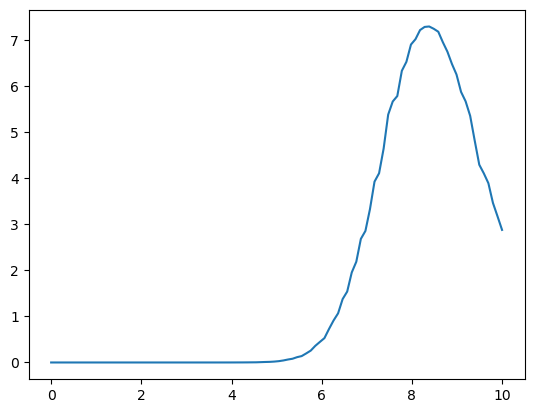

In [83]:
plt.plot(theta_V,likelihood_manual)

In [84]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(emulator.likelihoods[0], emulator.models[0])

In [85]:
likelihood = np.zeros(100)
for i in range(100):
    likelihood[i]=np.exp(mll(emulator.models[0]((torch.tensor(((newdf.iloc[i:i+1,:]-emulator.training_input_mean)/emulator.training_input_STD).values).float())),torch.tensor(((y_rep.iloc[i,0]-emulator.training_output_mean[0])/emulator.training_output_STD[0])).float()).detach().numpy())

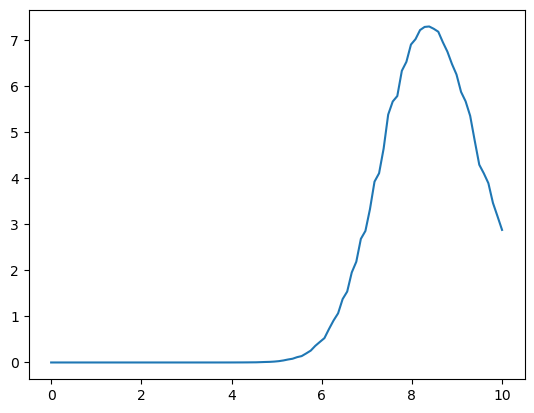

In [86]:
plt.plot(theta_V,likelihood)

In [472]:
x=np.linspace(-5,5,6)

In [473]:
y = x + np.random.normal(0,0.1,6)

In [474]:
x=(x-x.mean())/x.std()

In [475]:
y=(y-y.mean())/y.std()

In [477]:
x

array([-1.46385011, -0.87831007, -0.29277002,  0.29277002,  0.87831007,
        1.46385011])

In [523]:
X = torch.tensor(x)
Y=torch.tensor(y)
x_train, x_test, y_train, y_test = train_test_split(
    X.float(),
    Y.float(),
    test_size=2,
    random_state=seed
)

In [524]:
emulator = GPE.ensemble(pd.DataFrame(x_train),pd.DataFrame(y_train),mean_func="constant",training_iter=500)

0


In [525]:
x_test

tensor([-1.4639, -0.2928])

In [526]:
emulator.R2(pd.DataFrame(x_test),pd.DataFrame(y_test))

tensor([0.9786], grad_fn=<RsubBackward1>)

In [527]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-10, 10, 100)
    observed_pred = emulator.likelihoods[0](emulator.models[0](test_x))

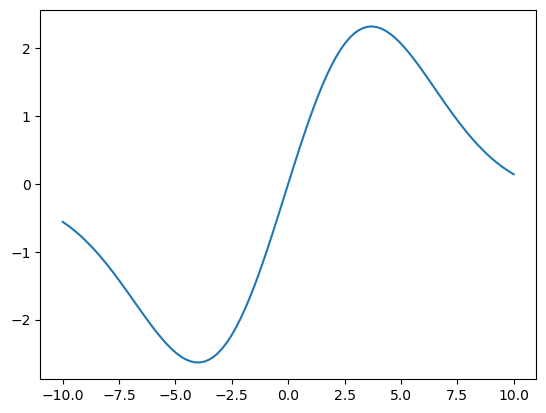

In [528]:
plt.plot(test_x,observed_pred.mean.numpy())

In [529]:
lower, upper = observed_pred.confidence_region()

In [530]:
lower

tensor([-4.8532, -4.8593, -4.8640, -4.8671, -4.8683, -4.8672, -4.8636, -4.8572,
        -4.8477, -4.8348, -4.8182, -4.7977, -4.7730, -4.7440, -4.7104, -4.6721,
        -4.6288, -4.5805, -4.5270, -4.4683, -4.4042, -4.3346, -4.2595, -4.1787,
        -4.0924, -4.0002, -3.9023, -3.7984, -3.6886, -3.5729, -3.4510, -3.3231,
        -3.1890, -3.0489, -2.9026, -2.7502, -2.5918, -2.4278, -2.2582, -2.0836,
        -1.9050, -1.7241, -1.5444, -1.3646, -1.1781, -0.9820, -0.7771, -0.5655,
        -0.3500, -0.1335,  0.0810,  0.2922,  0.4990,  0.7008,  0.8962,  1.0816,
         1.2509,  1.3998,  1.5268,  1.6314,  1.7132,  1.7714,  1.8053,  1.8147,
         1.7995,  1.7598,  1.6962,  1.6094,  1.5003,  1.3701,  1.2203,  1.0523,
         0.8681,  0.6693,  0.4580,  0.2363,  0.0060, -0.2306, -0.4715, -0.7149,
        -0.9587, -1.2012, -1.4407, -1.6756, -1.9046, -2.1264, -2.3399, -2.5443,
        -2.7388, -2.9228, -3.0960, -3.2581, -3.4090, -3.5487, -3.6773, -3.7952,
        -3.9027, -4.0002, -4.0881, -4.16

In [531]:
upper

tensor([ 3.7306,  3.6430,  3.5461,  3.4393,  3.3222,  3.1945,  3.0559,  2.9063,
         2.7455,  2.5738,  2.3912,  2.1982,  1.9953,  1.7833,  1.5630,  1.3355,
         1.1021,  0.8640,  0.6230,  0.3806,  0.1387, -0.1008, -0.3358, -0.5643,
        -0.7843, -0.9935, -1.1900, -1.3717, -1.5367, -1.6834, -1.8100, -1.9152,
        -1.9977, -2.0566, -2.0912, -2.1011, -2.0862, -2.0463, -1.9822, -1.8942,
        -1.7827, -1.6475, -1.4874, -1.3059, -1.1122, -0.9122, -0.7080, -0.5009,
        -0.2914, -0.0802,  0.1323,  0.3439,  0.5521,  0.7541,  0.9484,  1.1353,
         1.3181,  1.4988,  1.6764,  1.8496,  2.0173,  2.1788,  2.3341,  2.4829,
         2.6251,  2.7608,  2.8898,  3.0124,  3.1286,  3.2385,  3.3424,  3.4405,
         3.5329,  3.6198,  3.7015,  3.7780,  3.8496,  3.9164,  3.9785,  4.0362,
         4.0894,  4.1384,  4.1832,  4.2240,  4.2608,  4.2939,  4.3232,  4.3491,
         4.3715,  4.3907,  4.4068,  4.4200,  4.4305,  4.4385,  4.4443,  4.4480,
         4.4499,  4.4501,  4.4490,  4.44

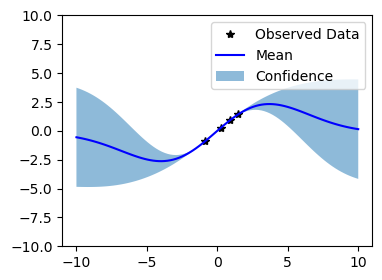

In [532]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train, y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-10, 10])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [533]:
emulator.models[0].likelihood.noise.item()

0.00010237279639113694

In [539]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPModel(x_train, y_train, likelihood)

In [540]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 1.329   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 1.294   lengthscale: 0.744   noise: 0.644
Iter 3/500 - Loss: 1.266   lengthscale: 0.797   noise: 0.598
Iter 4/500 - Loss: 1.245   lengthscale: 0.852   noise: 0.554
Iter 5/500 - Loss: 1.231   lengthscale: 0.905   noise: 0.513
Iter 6/500 - Loss: 1.223   lengthscale: 0.957   noise: 0.474
Iter 7/500 - Loss: 1.218   lengthscale: 1.003   noise: 0.438
Iter 8/500 - Loss: 1.212   lengthscale: 1.041   noise: 0.405
Iter 9/500 - Loss: 1.205   lengthscale: 1.066   noise: 0.374
Iter 10/500 - Loss: 1.196   lengthscale: 1.077   noise: 0.346
Iter 11/500 - Loss: 1.185   lengthscale: 1.075   noise: 0.319
Iter 12/500 - Loss: 1.172   lengthscale: 1.063   noise: 0.295
Iter 13/500 - Loss: 1.159   lengthscale: 1.044   noise: 0.272
Iter 14/500 - Loss: 1.147   lengthscale: 1.021   noise: 0.251
Iter 15/500 - Loss: 1.135   lengthscale: 0.999   noise: 0.231
Iter 16/500 - Loss: 1.123   lengthscale: 0.982   noise: 0.213
Iter 17/500 - Los

Iter 146/500 - Loss: 0.123   lengthscale: 3.474   noise: 0.000
Iter 147/500 - Loss: 0.123   lengthscale: 3.473   noise: 0.000
Iter 148/500 - Loss: 0.123   lengthscale: 3.472   noise: 0.000
Iter 149/500 - Loss: 0.122   lengthscale: 3.471   noise: 0.000
Iter 150/500 - Loss: 0.122   lengthscale: 3.471   noise: 0.000
Iter 151/500 - Loss: 0.122   lengthscale: 3.470   noise: 0.000
Iter 152/500 - Loss: 0.122   lengthscale: 3.469   noise: 0.000
Iter 153/500 - Loss: 0.122   lengthscale: 3.469   noise: 0.000
Iter 154/500 - Loss: 0.122   lengthscale: 3.468   noise: 0.000
Iter 155/500 - Loss: 0.121   lengthscale: 3.468   noise: 0.000
Iter 156/500 - Loss: 0.121   lengthscale: 3.467   noise: 0.000
Iter 157/500 - Loss: 0.121   lengthscale: 3.467   noise: 0.000
Iter 158/500 - Loss: 0.121   lengthscale: 3.467   noise: 0.000
Iter 159/500 - Loss: 0.121   lengthscale: 3.467   noise: 0.000
Iter 160/500 - Loss: 0.121   lengthscale: 3.466   noise: 0.000
Iter 161/500 - Loss: 0.120   lengthscale: 3.466   noise

Iter 277/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 278/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 279/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 280/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 281/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 282/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 283/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 284/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 285/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 286/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 287/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 288/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 289/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 290/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 291/500 - Loss: 0.114   lengthscale: 3.462   noise: 0.000
Iter 292/500 - Loss: 0.114   lengthscale: 3.462   noise

Iter 423/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 424/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 425/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 426/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 427/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 428/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 429/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 430/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 431/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 432/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 433/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 434/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 435/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 436/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 437/500 - Loss: 0.112   lengthscale: 3.461   noise: 0.000
Iter 438/500 - Loss: 0.112   lengthscale: 3.461   noise

In [541]:
model.likelihood.noise.item()

0.0001021757852868177

In [542]:
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-7, 7, 51)
    observed_pred = likelihood(model(test_x))

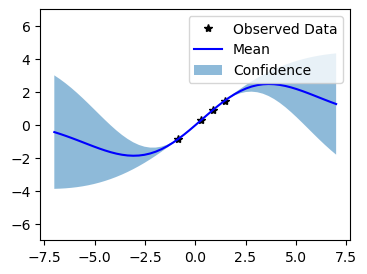

In [543]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-7, 7])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [547]:
observed_pred.covariance_matrix.shape

torch.Size([51, 51])

In [556]:
observed_pred = likelihood(model(test_x[1:2]))

In [557]:
observed_pred.covariance_matrix

tensor([[2.7542]], grad_fn=<AddBackward0>)